This script fits LSTM with keras using GloVec word representation.

In [1]:
import numpy as np
import pandas as pd
import nltk
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# read in processed data
train = pd.read_csv('../data/trainpp.csv')
test = pd.read_csv('../data/testpp.csv')

# top words
words = [w for line in train.reviewText for w in line.split()]
vocab = nltk.FreqDist(words)
print 'number of unique words in training data: %d' % len(vocab.keys())
ntop=10000
topwords = [p[0] for p in list(vocab.most_common(ntop))]
print 'consider top %d words' % ntop

# read in Global Vectors: https://nlp.stanford.edu/projects/glove/
# using top words only -- save computation
word_vec_dict = {}
with open('../data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        vec = line.strip().split()
        if vec[0] in topwords:
            word_vec_dict[vec[0]] = np.array(vec[1:], dtype=np.float64)
        
# word-index map
word2index={}
index2word={}
i=1
for word in sorted(word_vec_dict.keys()):
    word2index[word]=i
    index2word[i]=word
    i+=1

number of unique words in training data: 64836
consider top 10000 words


In [3]:
# read in word-index matrix for training and test sets
train_x = np.load('../data/trainIndex.npy')
test_x = np.load('../data/testIndex.npy')

dinput = train_x.shape[1]
print 'dimension of input review text: %d' % dinput

dimension of input review text: 1263


In [4]:
train_y = train.sentiment.values
test_y = test.sentiment.values

# train-validation split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,\
    test_size=0.3, random_state=1234, stratify = train_y)

* Construct a word embedding layer

In [5]:
def embeddingLayer(word_vec_dict, word2index):
    nword = len(word_vec_dict)
    dword = len(word_vec_dict.values()[0])
    
    mat = np.zeros((nword+1, dword))
    for word,vec in word_vec_dict.items():
        index = word2index[word]
        mat[index,:] = vec
        
    return Embedding(input_dim=nword+1, output_dim=dword, trainable=False, weights=[mat])

* LSTM model using keras

In [6]:
# construct LSTM layers

np.random.seed(1234)
X = Input(shape=(dinput,), dtype='int32')

embLayer = embeddingLayer(word_vec_dict, word2index)
emb = embLayer(X)

Y = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(emb)
#Y = Dropout(0.5)(Y)
#Y = LSTM(128, recurrent_dropout=0.5)(Y)
#Y = Dropout(0.5)(Y)
Y = Dense(1, activation='sigmoid')(Y)

model = Model(inputs = X, outputs = Y)

In [7]:
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1263)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1263, 100)         996000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,038,305
Trainable params: 42,305
Non-trainable params: 996,000
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 100, \
    validation_data=(X_val, y_val) )

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 792s - loss: 0.6933 - acc: 0.5003 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/10
17500/17500 [==============================] - 772s - loss: 0.6932 - acc: 0.4953 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
17500/17500 [==============================] - 770s - loss: 0.6932 - acc: 0.4951 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
17500/17500 [==============================] - 770s - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/10
17500/17500 [==============================] - 785s - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/10
17500/17500 [==============================] - 776s - loss: 0.6932 - acc: 0.4952 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/10
17500/17500 [==============================] - 772s - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/10
17500/17500 [========================

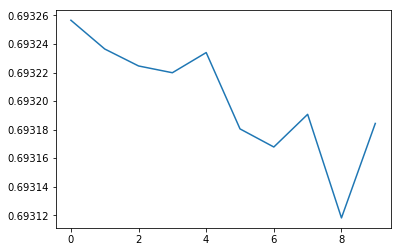

In [13]:
# fitting history
h = history.history.copy()
plt.plot(h['loss'])
#plt.plot(h['val_acc'])
#plt.plot(h['loss'])
#plt.plot(h['val_loss'])

In [14]:
# save model
with open('../data/lstm_model.json', 'w') as f:
    f.write(model.to_json())

# save model weights
model.save_weights('../data/lstm_model.h5')

In [ ]:
#from keras.models import model_from_json

# Load model structure
#with open('../data/lstm_model.json', "r") as f:
#    model1 = model_from_json(f.read())

# Load model weights
#model1.load_weights('../data/lstm_model.h5')

#model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#loss, acc = model1.evaluate(test_x, test_y)